In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import qutip as qt 
import sys
import os 

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from ECD_control.ECD_optimization.batch_optimizer import BatchOptimizer
from ECD_control.ECD_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
from ECD_control.ECD_pulse_construction.ECD_pulse_construction import *
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # Or any other font available on your system
from ECD_control.gate_definitions_qutip import *
from tensorflow.python.client import device_lib

2025-05-15 18:45:13.978465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747345514.005479   14406 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747345514.014240   14406 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747345514.038578   14406 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747345514.038607   14406 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747345514.038610   14406 computation_placer.cc:177] computation placer alr


Need tf version 2.3.0 or later. Using tensorflow version: 2.19.0



In [3]:
device_lib.list_local_devices()


W0000 00:00:1747345522.729053   14406 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1888368403744256250
 xla_global_id: -1]

### A first implementation of GKP States: As eigenstates of finite-energy Pauli operators

In [8]:
#The target oscillator state.

def gkp_square_states(N, Delta):
    """
    Constructs logical GKP square states in a truncated Hilbert space as the +1 and -1 eigenstates of finite-energy Z_Delta Pauli operator.
    The logical Pauli GKP states can then be obtained by linear combinations of those states. 

    Parameters:
    - N: int, dimension of the Hilbert space (truncation level).
    - Delta: float, squeezing parameter (controls the width of peaks).

    Returns:
    - psi_gkp: Qobj, the computational GKP square states as a QuTiP ket.
    """
   
    # Define infinite-energy Z Pauli operator
    q_op = qt.position(N)
    Z_0 = (1j *np.sqrt(np.pi)*q_op).expm()

    # Define the gaussian enveloppe operator 
    a_op = qt.destroy(N)
    adag_op = a_op.dag()
    E = (-Delta**2 *adag_op * a_op).expm()

    # Define the finite-energy Z Pauli operator 
    Z = E*Z_0*E.inv()
    

    # Determine the GKP codewords as the eigenstates of Z
    eigv, eigs = Z.eigenstates()
    # eigv = eigv.real
    
    # print(eigv)
    # print(eigs)

    psi_plus_Z = eigs[-1] # +1 eigenstate of Z
    psi_minus_Z = eigs[0] # -1 eigenstate of Z

    return (psi_plus_Z.unit(), psi_minus_Z.unit())
    # return ((E*psi_plus_Z_0).unit(), (E*psi_minus_Z_0).unit())



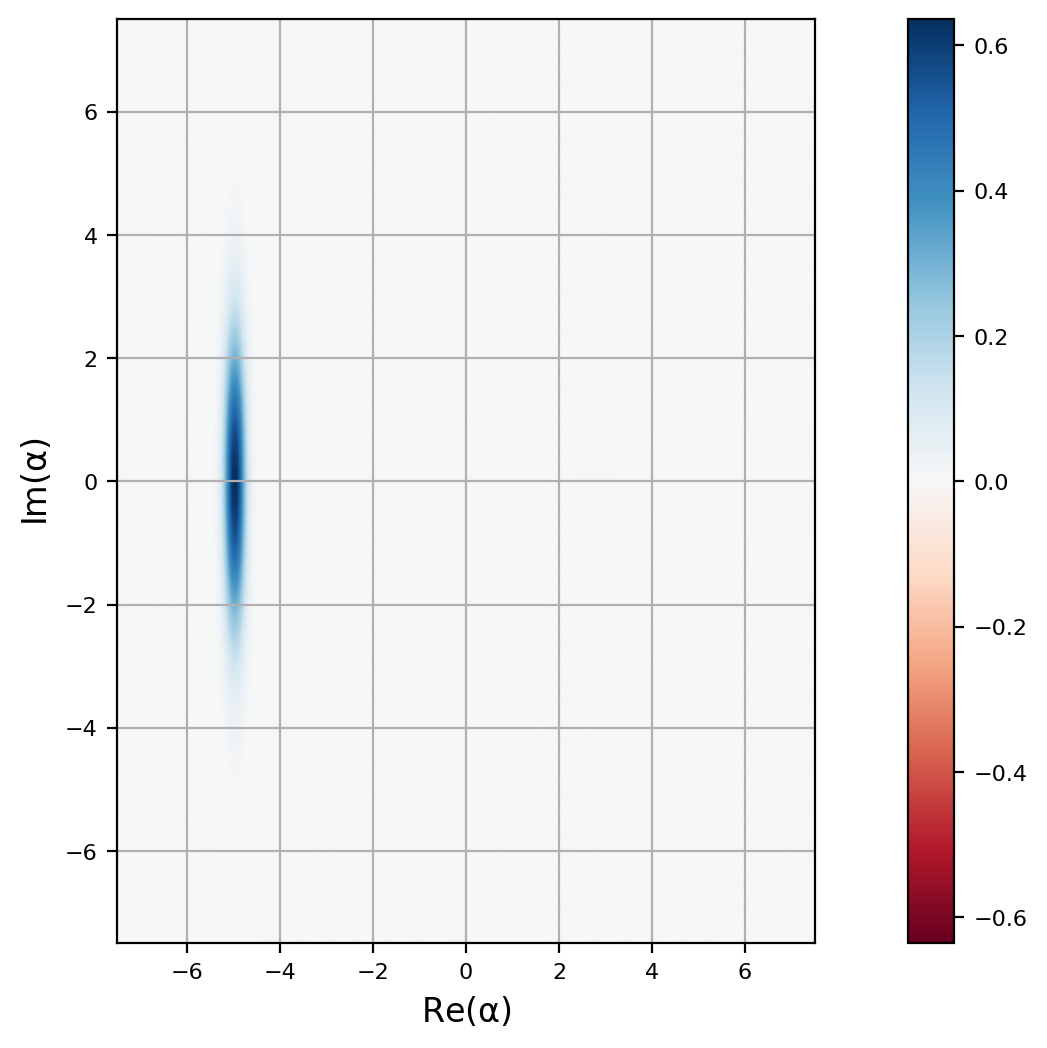

In [49]:
# Parameters
N = 100  # Hilbert space dimension
Delta = 0.306  # Squeezing parameter


psi_plus_Z, psi_minus_Z = gkp_square_states(N, Delta)
# print(type(psi_plus_Z))
# print(psi_plus_Z.norm())
# print(psi_plus_Z.type)
# print(psi_minus_Z)

xvec=np.linspace(-7.5,7.5,501)
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
ax.grid()
qt.visualization.plot_wigner(psi_plus_Z, xvec, xvec, colorbar=True, fig = fig,ax = ax, g = 2)
plt.savefig("../Figures/Wigner_visualization/psi_plus_Z_N_100_Delta_0.306.svg")
plt.savefig("../Figures/Wigner_visualization/psi_plus_Z_N_100_Delta_0.306.png")

### A second implementation: as ground states of the GKP Hamiltonian

In [4]:
# the target oscillator 

def gkp_square_states(N, omega, Ep, Eq, eta = 1, d = 2):
    """
    Constructs logical GKP square states in a truncated Hilbert space as the ground states of the GKP Hamiltonian.
    The logical Pauli GKP states can then be obtained by linear combinations of those states. 

    Parameters:
    - N: int, dimension of the Hilbert space (truncation level).
    - omega: float, frequency of the harmonic confinement giving rise to the finite-energy Hamiltonian
    - Ep, Eq: float,  energy scales along the directions q and p 
    - eta: float, aspect ratio in phase space. Set to 1 by default for a square lattice
    -d : int, degree of degeneracy for the ground state. Set to 2 by default to get computational GKP states

    Returns:
    - psi_gkp: Qobj, the computation GKP square states as a QuTiP ket.
    """

    # Define momentum and position operator
    p = qt.momentum(N)
    q = qt.position(N)

    # Define the weak harmonic confinement 
    H_harm = (omega/2)*(p**2 + q**2)

    # Define the cosine potentials 
    cos_p_op = ((np.sqrt(2*np.pi*d)/eta)*p).cosm()
    cos_q_op = ((eta*np.sqrt(2*np.pi*d))*q).cosm()

    # Define the finite-energy GKP Hamiltonian
    H = H_harm -Ep*cos_p_op - Eq*cos_q_op

    #  Find the ground states of the GKP Hamiltonian 
    eigv, eigs = H.eigenstates()

    # print(eigv)
    psi_plus_H = eigs[0]
    psi_minus_H = eigs[1]

    return (psi_plus_H,  psi_minus_H)

    


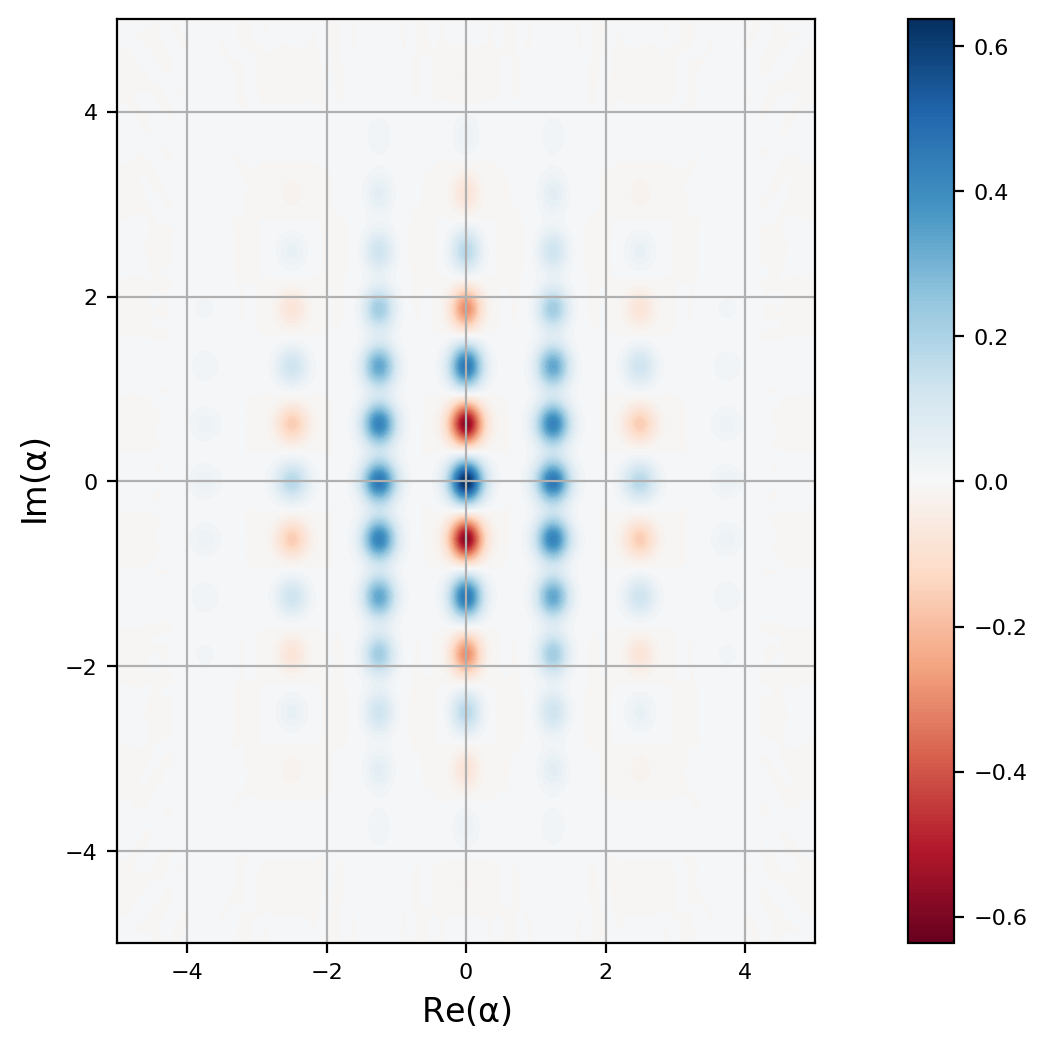

In [ ]:
N = 100
omega = 1
E = 10

psi_plus_H, psi_minus_H = gkp_square_states(N, omega, E, E)

# print(psi_plus_H.type)
# print(psi_plus_H.norm())


# Construct +Z GKP state from +-H states
psi_plus_Z = np.cos(np.pi/8) * psi_plus_H +np.sin(np.pi/8)*psi_minus_H
# print(psi_plus_Z.norm())
psi_minus_Z = np.sin(np.pi/8)*psi_plus_H - np.cos(np.pi/8)*psi_minus_H

xvec=np.linspace(-5,5,501)
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
ax.grid()
qt.visualization.plot_wigner(psi_minus_Z, xvec, xvec, colorbar=True, fig = fig,ax = ax, g = 2)
# plt.savefig("../Figures/Wigner_visualization/psi_minus_Z_N_100_E_10.svg")
# plt.savefig("../Figures/Wigner_visualization/psi_minus_Z_N_100_E_10.png")


# Define the target state 
psi_t = psi_minus_Z


In [6]:
#Optimization of ECD Circuit parameters (betas, phis, and thetas)
#the optimization options
opt_params = {
'N_blocks' : 7, #circuit depth
'N_multistart' : 200, #Batch size (number of circuit optimizations to run in parallel)
'epochs' : 200, #number of epochs before termination
'epoch_size' : 10, #number of adam steps per epoch
'learning_rate' : 0.01, #adam learning rate
'term_fid' : 0.995, #terminal fidelitiy
'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
'beta_scale' : 3.0, #maximum |beta| for random initialization
'initial_states' : [qt.tensor(qt.basis(2,0),qt.basis(N,0))], #qubit tensor oscillator, start in |g> |0>
'target_states' : [qt.tensor(qt.basis(2,1), psi_t)], #end in |e> |target>.
'name' : 'GKP_square_test', #name for printing and saving
'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}
#note: optimizer includes pi pulse in every ECD step. However, final ECD step is implemented 
#in experiment as a displacement since the qubit and oscillator should be disentangled at this point.
#So, we ask the optimizer to end in |e> |target> instead of |g>|target>.

In [7]:
#create optimization object. 
#initial params will be randomized upon creation
opt = BatchOptimizer(**opt_params)

#print optimization info. 
opt.print_info()

W0000 00:00:1747345607.730384   14406 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-05-15 18:46:50.732531: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 224000000 exceeds 10% of free system memory.
2025-05-15 18:46:50.834341: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 224000000 exceeds 10% of free system memory.
2025-05-15 18:46:50.871552: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 448000000 exceeds 10% of free system memory.


optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
final_disp_scale: 1.0
theta_scale: 3.141592653589793
include_final_displacement: False
real_part_only: False
name: GKP_square_test
comment: 
N_cav: 100
filename: GKP_square_test.h5

Best circuit parameters found:
betas:         [-0.32063-0.00322j  0.35126+1.17808j -0.1944 +1.5294j   0.01554+0.39374j
 -0.62936-0.31489j -1.29848-0.01429j -0.84691+0.6795j ]
final_disp:    [0.+0.j]
phis (deg):    [  17.25582 -156.81905  -61.50526  -16.45524   98.81071  -47.08866
  140.49678]
thetas (deg):  [-121.50585  -25.68982  -48.31347   75.74992  -31.79221 -157.4764
 -177.7832 ]
Max Fidelity:  0.225452




2025-05-15 18:46:50.982471: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 512000000 exceeds 10% of free system memory.


In [ ]:
#run optimizer.
#note the optimizer can be stopped at any time by interrupting the python console,
#and the optimization results will still be saved and part of the opt object.
#This allows you to stop the optimization whenever you want and still use the result.
opt.optimize()

Start time: 2025-05-15 18:47:07


2025-05-15 18:47:07.943639: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 224000000 exceeds 10% of free system memory.


 Epoch: 5 / 200 Max Fid: 0.702593 Avg Fid: 0.428315 Max dFid: 0.171431 Avg dFid: 0.059370 Elapsed time: 0:06:02.350444 Remaing time: 3:55:31.667300

In [9]:
#can print info, including the best circuit found.
opt.print_info() 

optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
final_disp_scale: 1.0
theta_scale: 3.141592653589793
include_final_displacement: False
real_part_only: False
name: GKP_square_test
comment: 
N_cav: 40
filename: GKP_square_test.h5

Best circuit parameters found:
betas:         [ 3.53563+0.12327j  3.55219-0.4321j  -0.03328+3.32671j -0.38482-0.84913j
  0.63372+1.76271j  0.20629-0.92834j -0.04455-0.08805j]
final_disp:    [0.+0.j]
phis (deg):    [-112.05751    3.39977  -21.59778 -148.59213  140.63582   47.21642
   42.10309]
thetas (deg):  [  90.02712  125.27685   92.34341 -112.92437 -139.4515   148.76012
   92.58399]
Max Fidelity:  0.784634




In [11]:
#can also get the best circuit parameters directly, could save this to a .npz file.
best_circuit =  opt.best_circuit()
betas = best_circuit['betas']
phis = best_circuit['phis']
thetas = best_circuit['thetas']
print(best_circuit)
np.savez('GKP_square_test', betas = betas, phis = phis, thetas = thetas) 

{'fidelity': np.float32(0.7846339), 'betas': array([ 3.5356307 +0.12326784j,  3.5521917 -0.4320961j ,
       -0.03328418+3.3267093j , -0.3848233 -0.84913105j,
        0.6337236 +1.7627132j ,  0.20629069-0.9283402j ,
       -0.04455206-0.08804729j], dtype=complex64), 'final_disp': array([0.+0.j], dtype=complex64), 'phis': array([-1.9557726 ,  0.05933714, -0.3769524 , -2.5934222 ,  2.4545581 ,
        0.82408214,  0.73483753], dtype=float32), 'thetas': array([ 1.5712698,  2.1864936,  1.6116965, -1.9709022, -2.433888 ,
        2.5963538,  1.6158955], dtype=float32)}
